# Signal to Noise Ratio

In any pattern recognition problem, we are trying to recognize the presence of particular patterns of interest, and distinguish them from other patterns of interest and patterns not of interest. By definition, in any pattern recognition problem, we will always need to contend with patterns that we are interested in to achieve our goals, and patterns that we are not interested in which distract from our goals. Unfortunately, nature is unpredictable and not always sympathetic to our goals, and patterns are subject to vary from occurrence to occurrence and vary in the time at which they occur and duration for which they occur. This is true both for patterns of interest and for patterns that distract us. Since both vary from occurrence to occurrence, some instances will be easier to distinguish than others. Since both vary in their times of occurrence, distracting patterns are likely to occur simultaneously with patterns of interest on some occasions.

In the field of *signal and image processing*, patterns we are interested in are called signals, and patterns we are not interested in are called noise. While we often think of noise as a static distribution (e.g., Gaussian noise) in trivial problems, in *practical* signal and image processing performed on real world data, noise can be any pattern that we are not interested in detecting, classifying, or acting on. While this is not explicitly a course on signal and image processing, having an understanding signals and noise from the viewpoint of signal and image processing will help us produce more robust machine learning models.

At any given time, there will be some mix of both signals and noise present in our data. We can say that the data received, $x_{R}$ is equal to the sum of the signal $x_{S}$ and the noise $x_{N}$,

$$
x_R = x_S + x_N.
$$

When specifying the performance of our models, we need a metric which helps us quantify their performance as the amount of distracting noise increases. That metric is the signal-to-noise ratio (SNR).

Without using any math, we can define SNR intuitively to start.

$$
\mathrm{SNR} = \frac{\mathrm{Amount\ of\ Signal\ in\ Data}}{\mathrm{Amount\ of\ Noise\ in\ Data}}
$$

As we get more signal, $X_S$, SNR increases. As we get more noise, $X_N$, SNR decreases.

But what quantifies "more" signal or more noise? How do we formally define the "amount" of signal or noise?

In the most basic definition, we use power. A more formal definition of SNR in terms of power in the signal and power in the noise is given by

$$
\mathrm{SNR} = P(x_S) / P(x_N)
$$

Here $P$ is the power of the signal,

$$
P(x) = \frac{1}{N} \sum_{n=1}^N x^2[n].
$$

Notice that this is really just quantifying (formally) what we mean when we say "more" signal. When the values of the signal get larger in either the positive or negative direction, their squares will get larger. The more large values there are, the larger the sum will be.

For a zero-mean Gaussian $x$, this is equivalent to the variance, $\mathrm{Var}[x] = \sigma^2$. While this fact is often exploited in toy problems, as we will see, the noise is almost never Gaussian in practice.

In practice, the noise can:
* take on a non-Gaussian distribution, especially a distribution skewed by physical or algorithmic processes which introduce bias,
* be non-stationary, with mean, variance, and higher order moments changing with respect to time,
* look similar to patterns of interest (not all noise needs to be completely random!),
* contain multiple mixed random and non-random components.

Further, in practice we will use different variations of the SNR definition for different applications, and see that each has some benefits and tradeoff.

In this notebook we will get some intuition for SNR by looking at some fundamental examples.

Discussion: Intuition

* Audio
* Images
* Sports

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

## SNR Units: Quick Look at Decibels

In [2]:
noise_pattern_1 = np.array([1, 1, 1, 1, 1, 1, 1, 1])
noise_pattern_2 = np.array([1, 0, 1, 0, 1, 0, 1, 0])

## Fundamental Example: Detecting a Pattern in Noise

In [3]:
def generate_dataset(n_samples_per_class):
    pattern_of_interest_1 = np.array([0, 0, 1, 0, 1, 0, 1, 0])  # 42
    pattern_of_interest_2 = np.array([0, 0, 0, 0, 1, 1, 0, 1])  # 13

    x_features_1 = np.tile(pattern_of_interest_1, (n_samples_per_class, 1))
    x_features_2 = np.tile(pattern_of_interest_2, (n_samples_per_class, 1))

    x_features = np.vstack((x_features_1, x_features_2))
    y_labels = np.array([0] * n_samples_per_class + [1] * n_samples_per_class)

    return x_features, y_labels


x_features, y_labels = generate_dataset(n_samples_per_class=100)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [5]:
x_train, x_test, y_train, y_test = train_test_split(
    x_features, y_labels, test_size=0.2, random_state=42
)

In [6]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
svm_classifier = SVC(kernel="linear", random_state=42)
rf_classifier.fit(x_train, y_train)
svm_classifier.fit(x_train, y_train)

SVC(kernel='linear', random_state=42)

In [7]:
y_inferred_rf = rf_classifier.predict(x_test)
y_inferred_svm = svm_classifier.predict(x_test)

accuracy_rf = accuracy_score(y_test, y_inferred_rf)
accuracy_svm = accuracy_score(y_test, y_inferred_svm)

print(f"Random Forest accuracy: {accuracy_rf * 100:.2f}%")
print(f"SVM accuracy: {accuracy_svm * 100:.2f}%")

Random Forest accuracy: 100.00%
SVM accuracy: 100.00%


In [8]:
def add_gaussian_noise(x_features, std=0.1):
    noise = np.random.normal(0, std, x_features.shape)
    x_noisy_features = x_features + noise
    return x_noisy_features


x_test_noisy = add_gaussian_noise(x_test, std=1)

In [9]:
y_inferred_noisy_rf = rf_classifier.predict(x_test_noisy)
accuracy_noisy_rf = accuracy_score(y_test, y_inferred_noisy_rf)

y_inferred_noisy_svm = svm_classifier.predict(x_test_noisy)
accuracy_noisy_svm = accuracy_score(y_test, y_inferred_noisy_svm)

print(f"Random Forest accuracy with noise: {accuracy_noisy_rf * 100:.2f}%")
print(f"SVM accuracy with noise: {accuracy_noisy_svm * 100:.2f}%")

Random Forest accuracy with noise: 80.00%
SVM accuracy with noise: 87.50%


In [10]:
sigma_values = np.arange(0.1, 3, 0.1)
accuracy_noisy_rf_values = np.zeros(sigma_values.shape)
n_repeats = 30

accuracies = []

epsilon = 1e-7

for _ in range(n_repeats):
    for sigma in sigma_values:
        x_test_noisy = add_gaussian_noise(x_test, std=sigma)
        y_inferred_noisy_rf = rf_classifier.predict(x_test_noisy)
        y_inferred_noisy_svm = svm_classifier.predict(x_test_noisy)
        accuracy_noisy_rf = accuracy_score(y_test, y_inferred_noisy_rf)
        accuracy_noisy_svm = accuracy_score(y_test, y_inferred_noisy_svm)
        noise = x_test_noisy - x_test
        mean_square_noise = np.mean(noise**2)
        mean_square_signal = np.mean(x_test**2)
        snr = mean_square_signal / (mean_square_noise + epsilon)
        snr_db = 10 * np.log10(snr)
        accuracies.append(
            {
                "Model": "RF",
                "Sigma": sigma,
                "SNR (dB)": snr_db,
                "Accuracy": accuracy_noisy_rf,
            }
        )
        accuracies.append(
            {
                "Model": "SVM",
                "Sigma": sigma,
                "SNR (dB)": snr_db,
                "Accuracy": accuracy_noisy_svm,
            }
        )

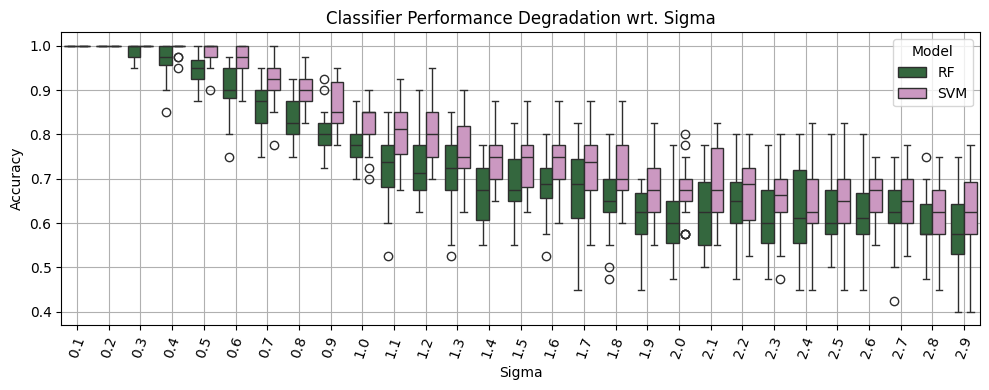

In [11]:
df = pd.DataFrame(accuracies)

plt.figure(figsize=(10, 4))
sns.boxplot(x="Sigma", y="Accuracy", hue="Model", data=df, palette="cubehelix")
locs, labels = plt.xticks()
xtick_labels = ["{:.1f}".format(sigma) for sigma in sigma_values]
plt.xticks(locs, xtick_labels, rotation=70)
plt.title("Classifier Performance Degradation wrt. Sigma")
plt.xlabel("Sigma")
plt.ylabel("Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()

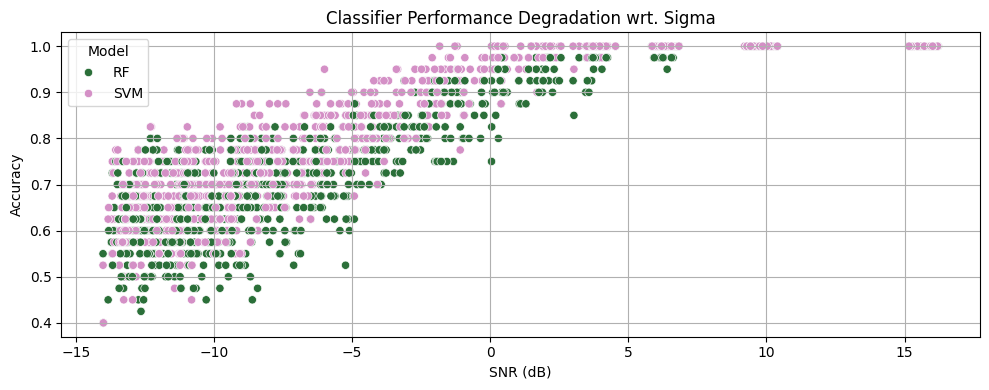

In [12]:
plt.figure(figsize=(10, 4))
sns.scatterplot(
    x="SNR (dB)", y="Accuracy", hue="Model", data=df, palette="cubehelix"
)
plt.title("Classifier Performance Degradation wrt. Sigma")
plt.xlabel("SNR (dB)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()

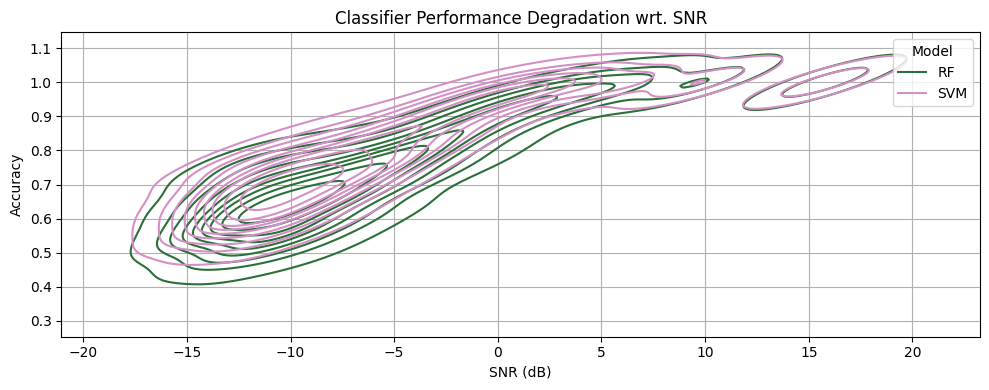

In [13]:
plt.figure(figsize=(10, 4))
sns.kdeplot(
    x="SNR (dB)", y="Accuracy", hue="Model", data=df, palette="cubehelix"
)
plt.title("Classifier Performance Degradation wrt. SNR")
plt.xlabel("SNR (dB)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()

observedbool, default False
This only applies if any of the groupers are Categoricals. If True: only show observed values for categorical groupers. If False: show all values for categorical groupers.

Deprecated since version 2.1.0: The default value will change to True in a future version of pandas

In [14]:
n_bins = 20
df["SNR (dB) Binned"] = pd.cut(df["SNR (dB)"], n_bins)
df["SNR (dB) Mean"] = df.groupby(["SNR (dB) Binned", "Model"], observed=True)[
    "SNR (dB)"
].transform("mean")
df["Accuracy Mean"] = df.groupby(["SNR (dB) Binned", "Model"], observed=True)[
    "Accuracy"
].transform("mean")

df.sort_values(by="SNR (dB) Mean", inplace=True)

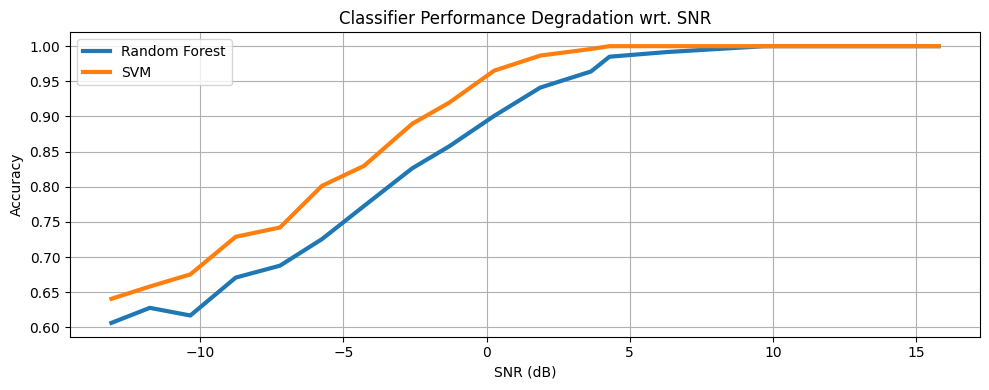

In [15]:
plt.figure(figsize=(10, 4))
plt.plot(
    df[df["Model"] == "RF"]["SNR (dB) Mean"],
    df[df["Model"] == "RF"]["Accuracy Mean"],
    linewidth="3",
)
plt.plot(
    df[df["Model"] == "SVM"]["SNR (dB) Mean"],
    df[df["Model"] == "SVM"]["Accuracy Mean"],
    linewidth="3",
)
plt.title("Classifier Performance Degradation wrt. SNR")
plt.legend(("Random Forest", "SVM"))
plt.xlabel("SNR (dB)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()

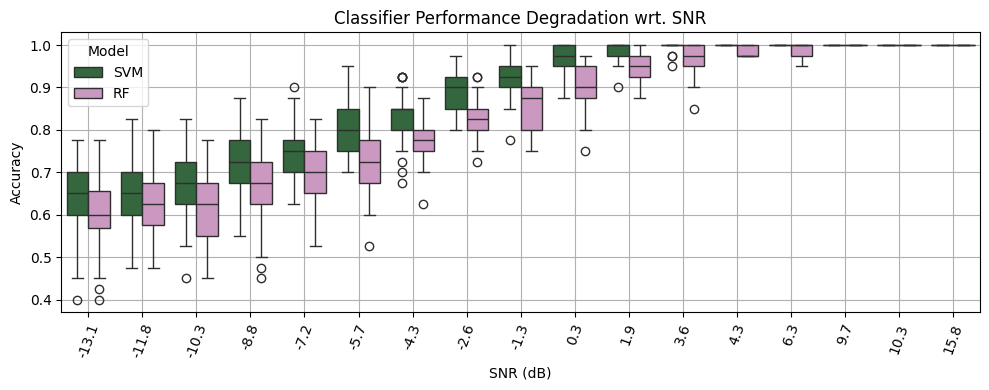

In [18]:
snr_mean_db_values = df["SNR (dB) Mean"].unique()

plt.figure(figsize=(10, 4))
sns.boxplot(
    x="SNR (dB) Mean", y="Accuracy", hue="Model", data=df, palette="cubehelix"
)
locs, labels = plt.xticks()
xtick_labels = [
    "{:.1f}".format(snr_mean_db) for snr_mean_db in snr_mean_db_values
]
plt.xticks(locs, xtick_labels, rotation=70)
plt.title("Classifier Performance Degradation wrt. SNR")
plt.xlabel("SNR (dB)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()

# Discussion: Defenses Against Noise

* Data augmentation (training on noisy data)
* Model architectures
* Exploiting prior knowledge
* Occam's razor
* Filtering
* Nonlinearity
* Drift detection
* Regularization
* Sanitization